# Document classification with simple neural networks

In this example, we'll try out a few different neural network models for classifying documents. We are going to consider a classical use case: sentiment polarity classification for product reviews.

The key takeaway is that we are going to consider different **representations** of documents. We will see a *bag-of-words* representation (BoW), a **continuous bag-of-words** representation (CBoW), and finally a representation based on a **convolutional neural network**. The first of these representations encodes each word using a one-hot vector, while the second and third approaches are **learned representations** built on top of **word embeddings**. At the end we will use nearest neighbors to analyze word embeddings.

### Reading the Amazon reviews, once again
You can download the dataset [here](http://www.cse.chalmers.se/~richajo/dat450/data/dredze_amazon_reviews.zip). This is the same corpus we saw in the topic modeling example.

The dataset consists of about 12,000 product reviews grouped into six product types (books, cameras, DVDs, music, health and software). The reviews are also tagged with sentiment polarity values (positive or negative). Our goal here will be to predict the sentiment labels.

Each line in the file consists of one review. For instance, in the following line
```
music neg 544.txt i was misled and thought i was buying the entire cd and it contains one song 
```
we have a music review with negative sentiment polarity. The third column is an ID we won't consider, and the rest of the line contains the words in the review text. The text has already been tokenized and lowercased.

We write a utility function that reads the documents and the corresponding sentiment and product type label. The function takes an optional argument `use_sentiment`: if this is True, we will use the sentiment labels as the output labels for our classification task; otherwise the product type labels will be used.

As usual, we also split the corpus into training and test sets.

In [1]:
from sklearn.model_selection import train_test_split

def read_data(corpus_file, use_sentiment=True):
    X = []
    Y = []
    with open(corpus_file, encoding='utf-8') as f:
        for line in f:
            product, sentiment, _, doc = line.strip().split(maxsplit=3)
            X.append(doc)
            Y.append(sentiment if use_sentiment else product)
    return X, Y

X, Y = read_data('../datasets/dredze_amazon_reviews.txt')
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

In [2]:
Xtrain[4], Ytrain[4]

("i bought this camera to replace a casio exilim ex-s500 that was sadly stolen from me . it 's the same size , which i love , and as convenient , which is awesome . it has a large bright screen to see the pictures you are taking or have taken . it 's one of my favorite things ever",
 'pos')

# Importing some utilities

In the self-study notebook for the first week, we created a class `NNClassifier` that deals with the machinery to set up a classifier that is trained using PyTorch. This includes all steps, most importantly the training loop. We have also added a class that deals with vocabulary management and encoding words as integers.

We have put that code into a separate Python file that you can download [here](http://www.cse.chalmers.se/~richajo/dat450/selfstudy_notebooks/doc_classification.zip). Put the Python file into the same directory as where your notebook is executing, and then import the class `NNClassifier` from `doc_classification` as a you would from regular library. If you get an error message here, then the file is in the wrong directory.

In [3]:
from doc_classification import NNClassifier

# Bag-of-words representations

Now that we have built the machinery to manage the documents, we have the tools needed to build neural networks for document classification.

We will now consider the **representation** of documents. Our first approach will be a classical **bag-of-words** representation, which consists of a (normalized) frequency count for each word type.

We follow the standard design pattern for PyTorch neural network components: we inherit from `nn.Module`, and implement the computation in a method called `forward`. By following this design pattern, we can (as we will see below) easily combine this representation component with other neural network components.

The input of this method takes a batch of documents, where the words are encoded as integers; the output is the bag-of-words representations of these documents.

In [4]:
import torch
from torch import nn

class BagOfWordsRepresentation(nn.Module):
    """A neural network module that represents documents using a bag-of-words approach."""
    
    def __init__(self, voc_size):
        super().__init__()
        self.voc_size = voc_size

    def forward(self, X):
        # X is a document tensor with shape (n_docs, n_words)
        n_docs, n_words = X.shape
        
        # Build one-hot vectors for all the words.
        onehot = torch.zeros(size=(n_docs, n_words, self.voc_size), device=X.device)
        onehot.scatter_(2, X.view(n_docs, n_words, 1), 1)

        # onehot shape (n_docs, n_words, voc_size)
        
        # Sum the one-hot vectors to get the frequencies for all words.
        bow = onehot.sum(dim=1)
        
        # Don't count the padding dummy word.
        bow[:,0] = 0
        
        # Normalize the word frequencies by the length of the documents.
        lengths = torch.sum(bow, dim=1)
        return (bow.t() / lengths).t()
    
        # shape of final tensor: (n_docs, voc_size)

As we saw in the first week's notebook, we structured our code so that we have to provide a *factory* function that builds the classifier neural network. This function will be called after the preprocessing has been carried out and we know useful information such as the vocabulary size and the number of output classes.

**Your work**: write the function that creates the neural network for document classification. Its first "block" should be the bag-of-words representation we declared above.

Some useful things to know:
- the output from the `BagOfWordsRepresentation` has the same size as the vocabulary size: `clf.voc_size`
- the number of output columns should be equal to the number of classes: `clf.n_classes`

In [5]:
def make_bow_nn(clf):
    
    neural_net = YOUR_CODE_HERE
    
    return neural_net

### Training the BoW model

Now, after all this preparatory work, let's train our first document classifier. As in the first self-study notebook, we wrap all hyperparameters in a container `ClassifierParameters`. This code includes some hyperparameter choices. You may try to tweak the parameters so that you find a setup that works for the model you declared in the previous step.

Typically, we see accuracies on the validation set around 0.81-0.82 for the sentiment classification task with this approach, depending on your random initialization and the hyperparameters.

Epochs: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 50/50 [00:36<00:00,  1.36it/s, val_loss=0.43, val_acc=0.81]


Text(0.5, 1.0, 'Accuracy')

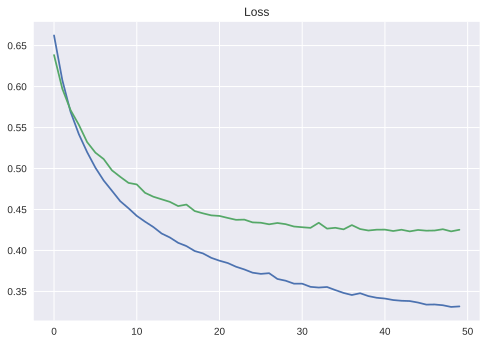

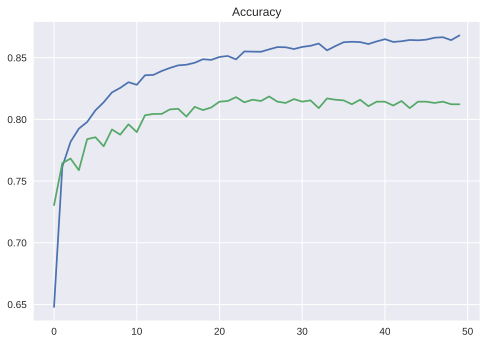

In [6]:
# We import the plotting library so that we can plot the learning curves.
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' 
plt.style.use('seaborn')

class ClassifierParameters:
    """Container class to store the hyperparameters that control the training process."""

    # Proportion of data set aside for validation.
    val_size = 0.2
    
    # Maximal vocabulary size: by increasing, the system will probably be slower but more accurate.
    max_voc_size = 1000    
    
    # Computation device: 'cuda' or 'cpu'
    device = 'cuda'
   
    # Number of training epochs.
    n_epochs = 50

    # Size of batches: how many documents to process in parallel.
    batch_size = 64

    # Learning rate in the optimizer.
    learning_rate = 2e-2

    # Weight decay (L2 regularization) in the optimizer.
    decay = 0
    
    # Dropout probability (if necessary).
    dropout = 0

# For reproducibility
torch.manual_seed(0)

# Initialize the text classifier
params = ClassifierParameters()    
bow_classifier = NNClassifier(params, make_bow_nn)

# Train the classifier.
bow_classifier.fit(Xtrain, Ytrain)

# Plot losses and accuracies for the training and validation sets.
plt.figure()
plt.plot(bow_classifier.history['train_loss'])
plt.plot(bow_classifier.history['val_loss'])
plt.title('Loss')

plt.figure()
plt.plot(bow_classifier.history['train_acc'])
plt.plot(bow_classifier.history['val_acc'])
plt.title('Accuracy')

Let's also exemplify how the classifier works by applying it to a couple of documents.

In [7]:
bow_classifier.predict(['i love this wonderful book !', 'i hate this awful toaster !'])

array(['pos', 'neg'], dtype='<U3')

To easily compute the accuracy on the held-out test set, we can use scikit-learn's `accuracy_score`.

In [8]:
from sklearn.metrics import accuracy_score
out = bow_classifier.predict(Xtest)
accuracy_score(Ytest, out)

0.80444817456987

# Continuous bag-of-words representation

Now that we have seen a "classical" approach to representing documents, let's consider a different approach. We will now represent each word using a *word embedding*: a continuous vector. The representation of a full document is constructed by computing the mean of all the word embeddings for the words in the the document. Similar representation approaches have been used in some research, such as [Joulin et al. (2017)](https://aclweb.org/anthology/E17-2068) and [Iyyer et al. (2015)](https://www.aclweb.org/anthology/P15-1162). Details are given as comments in the code.

Please not a crucial difference between the continuous bag-of-words representation and the classical bag-of-words representation: the former is a hand-crafted representation, and the latter is a ***learned*** representation, since the word embeddings are learned while we are training the document classifier. In later lectures, we will discuss many different learned representations.

**Your work**: 
- Create the initial word embeddings. You should probably use [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html).
- Implement the `forward` step of this representation component. This function carries out the computation for a batch. There are two things you need to do here:
  - For a given batch tensor, look up the word embeddings for all the words in the batch.
  - For each document, compute the mean of the word embeddings in this document. You may use [`torch.mean`](https://pytorch.org/docs/stable/generated/torch.mean.html) here or just call `mean` on the tensor.
  
**Hint**: if it is hard to follow what is going, it can be useful to insert print statements after each step so that you can observe the shape of each result. For instance, you may print the shape of `X`, `embedded`, and `doc_representations`.

In [9]:
class CBoWRepresentation(nn.Module):
    
    def __init__(self, voc_size, emb_dim):
        super().__init__()
        
        self.embedding = YOUR_CODE_HERE

    def forward(self, X):
        # X is a batch tensor with shape (batch_size, max_doc_length)
        
        # Look up the word embeddings for the words in the documents.
        # The result should have the shape (batch_size, max_doc_length, emb_dim)
        embedded = YOUR_CODE_HERE
       
        # As the document representations, we compute the mean over the second 
        # dimension (that is: over the words in each document).
        doc_representations = YOUR_CODE_HERE
        
        # The result should be a tensor of shape (batch_size, emb_dim)
        return doc_representations

**Your work**: write another factory function that creates the classifier neural network. You should now use the `CBoWRepresentation` as the first step.

**Hints:** 
- Look at the `ClassifierParameters` below. We have defined a hyperparameter `emb_dim` that you may use. You can access the parameter container as `clf.params`.
- The width of the output from the `CBoWRepresentation` will be the same as the word embedding dimensionality.

In [10]:
def make_cbow_nn(clf):
    
    neural_net = YOUR_CODE_HERE
    
    return neural_net    

We can now train the classifier with the new document representation. The code is almost identical. The accuracies are typically a bit higher now than before. Can you think of a reason why?

Epochs: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 50/50 [00:30<00:00,  1.62it/s, val_loss=0.42, val_acc=0.85]


Text(0.5, 1.0, 'Accuracy')

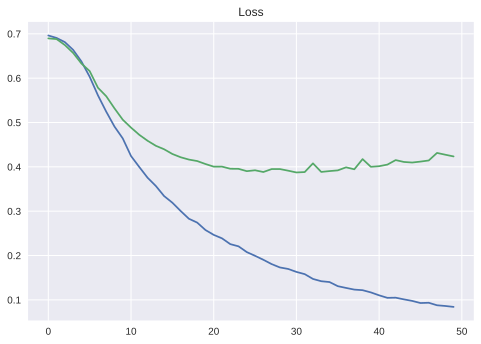

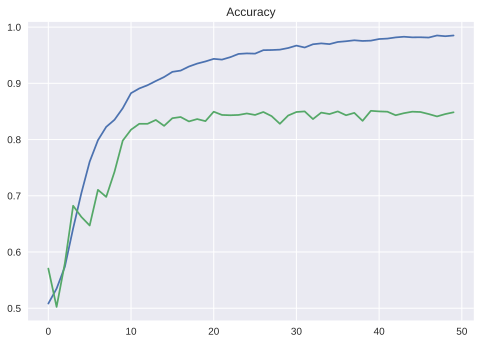

In [11]:
class ClassifierParameters:
    """Container class to store the hyperparameters that control the training process."""

    # Dimensionality of word embeddings.
    emb_dim = 32

    # I've typically observed that the learning rates need to be a bit lower for this model.
    learning_rate = 3e-3

    # Since we are using word embeddings now, it is easier to use all words.
    max_voc_size = None    
    
    # The rest of the hyperparameters are the same as above.
    val_size = 0.2
    device = 'cuda'
    n_epochs = 50
    batch_size = 64
    decay = 0
    dropout = 0


# The rest is identical to the code above, except for the factory function.
torch.manual_seed(0)

params = ClassifierParameters()    
cbow_classifier = NNClassifier(params, make_cbow_nn)
cbow_classifier.fit(Xtrain, Ytrain)

plt.figure()
plt.plot(cbow_classifier.history['train_loss'])
plt.plot(cbow_classifier.history['val_loss'])
plt.title('Loss')
plt.figure()
plt.plot(cbow_classifier.history['train_acc'])
plt.plot(cbow_classifier.history['val_acc'])
plt.title('Accuracy')

Again, just as a sanity check, let's apply the classifier to the same two test documents.

In [12]:
cbow_classifier.predict(['i love this wonderful book', 'i hate this awful toaster !'])

array(['pos', 'neg'], dtype='<U3')

In [13]:
accuracy_score(Ytest, cbow_classifier.predict(Xtest))

0.8384389425094418

## Representations based on CNNs

The next representation model we'll try is a *convolutional neural network* (CNN).  The interesting components here are the following:

- the convolutional layer: [`nn.Conv1d`](https://pytorch.org/docs/stable/nn.html\#torch.nn.Conv1d)

- the pooling layer: [`nn.AdaptiveMaxPool1d`](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveMaxPool1d.html)
or [`nn.AdaptiveAvgPool1d`](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool1d.html)

**Your work**:
- Again, we implement the constructor `__init__`, which creates the building blocks, and then `forward` which carries out the computation.
- In the constructor, create the embedding layer, convolutional layer, activation function, and pooling layer.
- In `forward`, carry out the following steps:
  - Look up word embeddings for all the words. This will be the same as in `CBoWRepresentation`.
  - Apply the convolutional layer to the tensor with the word embeddings you looked up.
  - Apply the activation function.
  - Apply the pooling layer.
  
**Hint**:
- `params` is the `ClassifierParams` declared below and it contains various hyperparameters you will need.

In [14]:
class CNNRepresentation(nn.Module):
    
    def __init__(self, voc_size, params):
        super().__init__()        
                        
        # Embedding layer.
        self.embedding = YOUR_CODE_HERE
        
        # Convolutional layer.
        self.conv = YOUR_CODE_HERE
        
        # An activation function that will be applied to the feature maps.
        self.activation = YOUR_CODE_HERE

        # For all feature maps, we'll apply a pooling operation over the whole sentence.
        # So we use an *adaptive* average or max pooling, with the number of regions set to 1.
        self.pooling = YOUR_CODE_HERE
            
        
    def forward(self, texts):
        # The words in the documents are encoded as integers. The shape of the documents
        # tensor is (batch_size, max_length).
        
        # First look up the embeddings for all the words in the documents.
        # The shape is now (batch_size, max_length, emb_dim).
        embedded = YOUR_CODE_HERE
        
        # We need to "flip" the tensor so that it fits with the 1-dimensional convolution.
        # That is, the dimension over (the words) which we convolve needs to be the last one.
        # The shape is now (batch_size, emb_dim, max_length)
        embedded_t = embedded.transpose(1,2)

        # apply the convolution and the activation to get the feature map.
        feature_map = YOUR_CODE_HERE
                
        # The shape of the feature map will be (batch_size, n_channels, feature_map_length)
        # where feature_map_length will depend on how you set up your Conv1d layer.
            
        # We apply the pooling operation. Since we pool over the whole sentence for each channel,
        # the result now has the shape (batch_size, n_channels, 1).

        pooled = YOUR_CODE_HERE
                        
        # View the result as a two-dimensional tensor of shape (n_docs, n_channels_in_total)
        # The squeeze operation "hides" the third dimension of the tensor.
        out = pooled.squeeze(2)
        
        return out
            

**Your work**: write the factory function again, this time using the `CNNrepresentation` as the first step.

**Hints:** 
- The parameter object is `clf.params`.
- The width of the output from the `CNNRepresentation` will be the same as the number of channels.

In [15]:
def make_cnn(clf):
    
    neural_net = YOUR_CODE_HERE
    
    return neural_net

Again, we make a container containing the hyperparameters and then train the classifier.

Epochs: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 25/25 [00:22<00:00,  1.12it/s, val_loss=0.38, val_acc=0.86]


Text(0.5, 1.0, 'Accuracy')

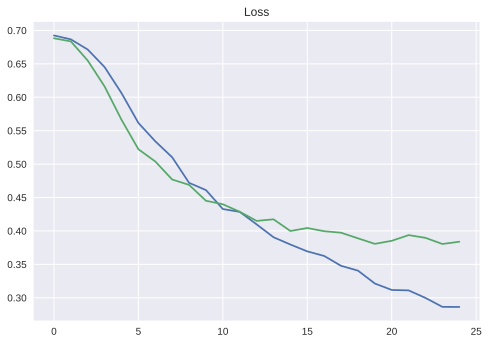

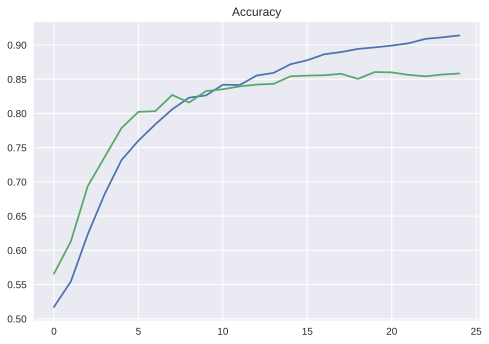

In [16]:
class ClassifierParameters:
    """Container class to store the hyperparameters that control the training process."""

    # Number of channels used in the convolutional layer.
    n_channels = 16
    # Length of the convolutional kernels (filters).
    conv_kernel_size = 3

    # Word embedding size.
    emb_dim = 64
    
    # I found that this model works better with a bit of regularization, but you will still get
    # OK performance with the settings we used above.
    decay = 1e-4
    dropout = 0.3333
        
    # The rest is as above.
    val_size = 0.2
    max_voc_size = None
    device = 'cuda'
    n_epochs = 25
    batch_size = 64
    learning_rate = 3e-3

torch.manual_seed(0)

# Initialize the text classifier
params = ClassifierParameters()    
cnn_classifier = NNClassifier(params, make_cnn)

# Train the classifier.
cnn_classifier.fit(Xtrain, Ytrain)

# Plot losses and accuracies for the training and validation sets.
plt.figure()
plt.plot(cnn_classifier.history['train_loss'])
plt.plot(cnn_classifier.history['val_loss'])
plt.title('Loss')

plt.figure()
plt.plot(cnn_classifier.history['train_acc'])
plt.plot(cnn_classifier.history['val_acc'])
plt.title('Accuracy')


# Inspecting the word embeddings

The following function computes the nearest neighbors in the word embedding space to a given word, according to the [cosine similarity score](https://en.wikipedia.org/wiki/Cosine_similarity).

Here, `emb` is an object of the type [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html), and `voc` is a `Vocabulary` object from the helper code we imported in the beginning.

In [17]:
def nearest_neighbors(emb, voc, word, n_neighbors=5):
        
    # Encode the words as integers, and put them into a PyTorch tensor.    
    word_index = torch.as_tensor([voc.stoi[word]])
    word_index = word_index.to(emb.weight.device)
    
    # Look up the embedding for the test word.
    test_emb = emb(word_index)
        
    # We'll use a cosine similarity function to find the most similar words.
    sim_func = nn.CosineSimilarity(dim=1)
    cosine_scores = sim_func(test_emb, emb.weight)
 
    # Find the positions of the highest cosine values.
    near_nbr = cosine_scores.topk(n_neighbors+1)
    topk_cos = near_nbr.values[1:]
    topk_indices = near_nbr.indices[1:]
    # NB: the first word in the top-k list is the query word itself!
    # That's why we skip the first position in the code above.
    
    # Finally, map word indices back to strings, and put the result in a list.
    out = [ (voc.itos[ix.item()], cos.item()) for ix, cos in zip(topk_indices, topk_cos) ]
    return out

Let's run the function that was provided. For the embeddings you learned in the CBoW or CNN model, you can now list the nearest neighbors of a given word in the embedding space.

**Hints**:
- Assuming your classifier is `clf`, you can get the vocabulary object as `clf.voc`.
- The neural network model can be accessed as `clf.model`.
- If your `CBowRepresentation` is the first step in a `Sequential`, then you can get it as `clf.model[0].embedding`.

**Experiments**:
- For the CBoW or CNN model, list the nearest neighbors of some words you think are indicative of positive or negative sentiment in a review. What are the results?
- Then list the nearest neighbors for some other word. Can you think of a reason why the result seems more confusing now?
- Optionally, retrain your CBoW or CNN model using the product type instead of the sentiment polarity as the label for supervision. That is, we don't want to distinguish positive and negative reviews, but instead distinguish book reviews, software reviews, music reviews etc. Inspect the neighbors of some selected words again.



# Bonus: reimplementing Kim (2014)

To make things a bit more interesting, let's replicate the approach described in the famous paper by [Kim (2014)](https://www.aclweb.org/anthology/D14-1181). (One difference is that we won't use any *pre-trained* word embeddings, which will be covered in the next lecture.) The structure can be visualized as follows:

<img src="http://www.cse.chalmers.se/~richajo/dat450/selfstudy_notebooks/images/word_cnn.png
" alt="CNN model" style="width: 500px;"/>

We declare three different convolutional layers, which will be applied in parallel and whose outputs will be "glued" together in the `forward` method. The reason for this solution is to allow convolutional filters of different sizes. 

The steps are described in a more detailed fashion as comments in the code below.

In [21]:
class KimCNNRepresentation(nn.Module):
    
    def __init__(self, voc_size, params):
        super().__init__()        
                                
        # Convolutional layers of length 2, 3, and 4.
        self.conv1 = YOUR_CODE_HERE
        self.conv2 = YOUR_CODE_HERE
        self.conv3 = YOUR_CODE_HERE
    
        # The rest should be the same as above.
        self.embedding = YOUR_CODE_HERE
        self.activation = YOUR_CODE_HERE
        self.pooling = YOUR_CODE_HERE
                    
        
    def forward(self, texts):
        
        embedded = YOUR_CODE_HERE 
        
        embedded_t = embedded.transpose(1,2)

        # We now apply the convolutional layers in parallel, and then the ReLU activation.
        # After these operations, each feature map now has the shape (n_docs, n_channels, max_len-size+1)
        # where n_channels is the number of "patterns" each convolutional layer looks for,
        # and size is the size of the convolutional filter.
        fmap1 = YOUR_CODE_HERE
        fmap2 = YOUR_CODE_HERE
        fmap3 = YOUR_CODE_HERE
                           
        # We apply the pooling operation. Since we pool over the whole sentence for each channel,
        # the results now have the shape (n_docs, n_channels, 1) for each convolutional filter.
        pooled1 = YOUR_CODE_HERE 
        pooled2 = YOUR_CODE_HERE
        pooled3 = YOUR_CODE_HERE
                    
        # We "glue" the results from all convolutional layers.
        # Shape: (n_docs, n_channels_in_total, 1)
        all_pooled = torch.cat([pooled1, pooled2, pooled3], 1)

        return all_pooled.squeeze(2)        